# **IDL Project: Predicting BCI_EEG signals using Deep Learning**

In [1]:
!pip install wandb --quiet
import os

import torch
import torch.nn as nn
from torchsummary import summary
import torchvision

import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import glob
import wandb
import matplotlib.pyplot as plt
import multiprocessing as mp
import scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.4 MB/s eta 0:00:00


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cpu


In [3]:
# Get BCI_EEG Data 
!mkdir /content/bci_data
!wget -q https://cmu.box.com/shared/static/dje4whisfwszhe2vvfphvahzr563kp2x.zip --content-disposition --show-progress
!unzip -qo 'BCI_EEG_data.zip' -d '/content/bci_data'

"""
Original Data From:
 *https://figshare.com/articles/online_resource/Shared_data_for_exploring_training_effect_in_42_human_subjects_using_a_noninvasive_sensorimotor_rhythm-based_online_BCI/7959572*
"""

BCI_EEG_data.zip    100%[===================>]   4.84G  12.7MB/s    in 7m 47s  


'\nOriginal Data From:\n *https://figshare.com/articles/online_resource/Shared_data_for_exploring_training_effect_in_42_human_subjects_using_a_noninvasive_sensorimotor_rhythm-based_online_BCI/7959572*\n'

# **EDA**

---
...Each file includes the online results from the BCI experimentation for each run (saved in a cell variable ‘BCI_UseResults’), key parameters for the experiment (saved in a structure ‘Experiment_Parm’), key parameters for the state of the raw EEG signal (saved in a structure ‘Experimental_states’), and the raw EEG signal (saved in a variable ‘output_data’).

The raw EEG signals for experiments one and two are composed of 62 channels of EEG data with a sampling frequency of 100Hz, while data for experiment three contains 64 channels of EEG sampled at 128Hz...

In [5]:
# Loads a single .mat file into dictionary where {key=str, value=np.ndarray}
mat = scipy.io.loadmat('/content/bci_data/Exp1/Subj10_S01_Exp1.mat') 

#HIgh-Level Description of Dataset
#print(mat.keys())
#for i in mat.keys():
#    print(f'Dictionary Key: {i} (dtype: {type(i)})')
#    if isinstance(mat[i], np.ndarray):
#        print(f'Dictionary Value (dtype: {type(mat[i])}) shape: {mat[i].shape} ')
#    else: print(f'{mat[i]}')

#New variable to load formatted data
dat = dict()
dat['raw_eeg'] = mat['output_data']
 
# Reformatting 'BCI_UseResults' into a dictionary
bci_useresults = dict()
for i in mat['BCI_UseResults']:
    bci_useresults[i[1][0]] = i[0].flatten()

dat['bci_useresults'] = bci_useresults #Add formatted data to dictionary

# Reformatting 'Experiment_Parm' into a dictionary
exp_parm = dict()
for _ in mat['Experiment_Parm']:
    for wrapper in _:
        fieldnames = wrapper.dtype.names
        for idx, val in enumerate(wrapper):
            exp_parm[f'{fieldnames[idx]}'] = val.flatten()

dat['exp_parm'] = exp_parm

# Reformatting 'Experimental_states' into a dictionary
exp_states = dict()
for _ in mat['Experimental_states']:
    for wrapper in _:
        fieldnames = wrapper.dtype.names
        for idx, val in enumerate(wrapper):
            exp_states[f'{fieldnames[idx]}'] = val.flatten()

dat['exp_states'] = exp_states

print(f'New variable "dat" has keys: {dat.keys()}')
for key in dat.keys():
    print('--------------------------------')
    if key != 'raw_eeg':  
        print(f'Key: [{key}] contains a nested dictionary as its value:')
        for j in dat[key].keys():
            print(f'(Nested) Key: {j} ->  Input Shape: {dat[key][j].shape}')
    else: print(f'Key:[{key}] -> Input Shape:{dat[key].shape}')

New variable "dat" has keys: dict_keys(['raw_eeg', 'bci_useresults', 'exp_parm', 'exp_states'])
--------------------------------
Key:[raw_eeg] -> Input Shape:(142080, 62)
--------------------------------
Key: [bci_useresults] contains a nested dictionary as its value:
(Nested) Key: Number of trials in each run ->  Input Shape: (5,)
(Nested) Key: Number of trials hitting the targets ->  Input Shape: (5,)
(Nested) Key: Number of trials abort ->  Input Shape: (5,)
(Nested) Key: The percent valid correct for each run ->  Input Shape: (5,)
(Nested) Key: Information transfer rate for each run ->  Input Shape: (5,)
--------------------------------
Key: [exp_parm] contains a nested dictionary as its value:
(Nested) Key: PreFeedbackDuration ->  Input Shape: (1,)
(Nested) Key: SamplingFrequency ->  Input Shape: (1,)
(Nested) Key: PostFeedbackDuration ->  Input Shape: (1,)
(Nested) Key: ITIDuration ->  Input Shape: (1,)
(Nested) Key: Channels ->  Input Shape: (62,)
(Nested) Key: Description ->  I

In [ ]:
"""
TODOs: 
1. Format the 'output_data' into torch.Tensor to make it trainable on a neural network
"""
        
# Attempt 1: Use Pandas to display the exp_ s
df_exp_states = pd.DataFrame.from_dict(exp_states)
display(df_exp_states)
df_exp_states['CursorPosX'].unique()
df_exp_states['TargetCode'].unique()

,TargetCode,ResultCode,Feedback,CursorPosX,CursorPosY
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
142075,2,2,0,520,2047
142076,2,2,0,520,2047
142077,2,2,0,520,2047
142078,2,2,0,520,2047


array([0, 2, 1], dtype=uint8)

In [ ]:
 # YHH
# targets = mat['Experimental_states']['TargetCode']
# targets = targets[0][0]
# targets = np.squeeze(targets)
# print(targets)
# print(exp_states['TargetCode'])
# exp_states['CursorPosX']
targets = exp_states['TargetCode']
# trial_start_index = np.nonzero(np.diff(targets))[0][::2]+1
# trial_start_end_index = np.nonzero(np.diff(targets))[0]+1
test = np.nonzero(np.diff(targets))[0]+1
print(test)

In [6]:
targets = mat['Experimental_states']['TargetCode']
cursor = mat['Experimental_states']['CursorPosX']

targets = targets[0][0]
targets = np.squeeze(targets)

# Maybe we can use the dict that Robin prepared to extract the targets?
targets = exp_states['TargetCode']
results = exp_states['ResultCode']
# cursor = exp_states['CursorPosX']

raw_eeg = mat['output_data']

# Get indices for the start/end of  each trial
trial_start_index = np.nonzero(np.diff(targets))[0][::2]+1
trial_start_end_index = np.nonzero(np.diff(targets))[0]+1

# labels to ConvNet in one data file
targets = targets[trial_start_index]
results = results[trial_start_index]
print("labels: ")
print(targets.shape)
print(targets)
print(results)
print('-----------------------------------------------')
print("minimum trial duration: ", np.amin(np.diff(trial_start_end_index)[::2]))

raw_eeg = np.split(raw_eeg,trial_start_end_index)[1::2]
input = []

for eeg in raw_eeg:
  # index 210 to 310 (1s) because the motor imgination starts 2s after the target shows up. 210 is 2s (200) plus 0.1s (10) reaction time. 
  # The target will freeze on the screen for 1s and the shortest trial only lasts for 4.3 seconds so the upper bound needs to be <330, 4.32 (432) minus 1s (100).
  # 310 is taken to round to 100
  input.append(eeg[210:310,:])

# inputs to ConvNet in one data file
input = np.array(input)
print("input: ")
print(input.shape)






labels: 
(125,)
[2 1 2 1 1 2 1 2 1 2 1 2 2 1 2 1 2 1 2 1 2 1 1 2 1 2 2 1 1 2 1 2 1 2 2 1 2
 1 2 1 2 1 2 1 1 2 1 2 2 1 1 2 1 2 2 1 2 1 2 1 1 2 1 2 2 1 1 2 1 2 1 2 2 1
 1 2 2 1 2 1 2 1 2 1 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 1 2 2 1 2 1 2 1 1 2 1
 2 2 1 1 2 1 2 1 2 1 2 2 1 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
-----------------------------------------------
minimum trial duration:  432
input: 
(125, 100, 62)


There are total of 125 trials in each data file. The code below visualizes the first three trials with curosr position on the left and eeg signals o nthe right.

# Visualization

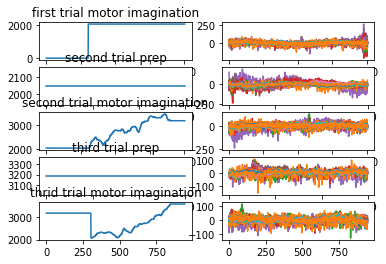

In [7]:
# DataData Visualization
import matplotlib.pyplot as plt

cursor = mat['Experimental_states']['CursorPosX']
cursor = cursor[0][0]
cursor = np.squeeze(cursor)
raw_eeg = mat['output_data']

plt.subplot(5,2,1)
plt.plot(cursor[trial_start_end_index[0]:trial_start_end_index[1]]);
plt.title("first trial motor imagination")
plt.subplot(5,2,2)
plt.plot(raw_eeg[trial_start_end_index[0]:trial_start_end_index[1],:]);

plt.subplot(5,2,3)
plt.plot(cursor[trial_start_end_index[1]:trial_start_end_index[2]]);
plt.title("second trial prep")
plt.subplot(5,2,4)
plt.plot(raw_eeg[trial_start_end_index[1]:trial_start_end_index[2],:]);

plt.subplot(5,2,5)
plt.plot(cursor[trial_start_end_index[2]:trial_start_end_index[3]]);
plt.title("second trial motor imagination")
plt.subplot(5,2,6)
plt.plot(raw_eeg[trial_start_end_index[2]:trial_start_end_index[3],:]);

plt.subplot(5,2,7)
plt.plot(cursor[trial_start_end_index[3]:trial_start_end_index[4]]);
plt.title("third trial prep")
plt.subplot(5,2,8)
plt.plot(raw_eeg[trial_start_end_index[3]:trial_start_end_index[4],:]);

plt.subplot(5,2,9)
plt.plot(cursor[trial_start_end_index[4]:trial_start_end_index[5]]);
plt.title("thrid trial motor imagination")
plt.subplot(5,2,10)
plt.plot(raw_eeg[trial_start_end_index[4]:trial_start_end_index[5],:]);

In [8]:
# Loads a single .mat file into dictionary where {key=str, value=np.ndarray}
mat = scipy.io.loadmat('/content/bci_data/Exp1/Subj10_S01_Exp1.mat') 

#HIgh-Level Description of Dataset
#print(mat.keys())
#for i in mat.keys():
#    print(f'Dictionary Key: {i} (dtype: {type(i)})')
#    if isinstance(mat[i], np.ndarray):
#        print(f'Dictionary Value (dtype: {type(mat[i])}) shape: {mat[i].shape} ')
#    else: print(f'{mat[i]}')

#New variable to load formatted data
dat = dict()
dat['raw_eeg'] = mat['output_data']
 
# Reformatting 'BCI_UseResults' into a dictionary
bci_useresults = dict()
for i in mat['BCI_UseResults']:
    bci_useresults[i[1][0]] = i[0].flatten()

dat['bci_useresults'] = bci_useresults #Add formatted data to dictionary

# Reformatting 'Experiment_Parm' into a dictionary
exp_parm = dict()
for _ in mat['Experiment_Parm']:
    for wrapper in _:
        fieldnames = wrapper.dtype.names
        for idx, val in enumerate(wrapper):
            exp_parm[f'{fieldnames[idx]}'] = val.flatten()

dat['exp_parm'] = exp_parm

# Reformatting 'Experimental_states' into a dictionary
exp_states = dict()
for _ in mat['Experimental_states']:
    for wrapper in _:
        fieldnames = wrapper.dtype.names
        for idx, val in enumerate(wrapper):
            exp_states[f'{fieldnames[idx]}'] = val.flatten()

dat['exp_states'] = exp_states

print(f'New variable "dat" has keys: {dat.keys()}')
for key in dat.keys():
    print('--------------------------------')
    if key != 'raw_eeg':  
        print(f'Key: [{key}] contains a nested dictionary as its value:')
        for j in dat[key].keys():
            print(f'(Nested) Key: {j} ->  Input Shape: {dat[key][j].shape}')
    else: print(f'Key:[{key}] -> Input Shape:{dat[key].shape}')

New variable "dat" has keys: dict_keys(['raw_eeg', 'bci_useresults', 'exp_parm', 'exp_states'])
--------------------------------
Key:[raw_eeg] -> Input Shape:(142080, 62)
--------------------------------
Key: [bci_useresults] contains a nested dictionary as its value:
(Nested) Key: Number of trials in each run ->  Input Shape: (5,)
(Nested) Key: Number of trials hitting the targets ->  Input Shape: (5,)
(Nested) Key: Number of trials abort ->  Input Shape: (5,)
(Nested) Key: The percent valid correct for each run ->  Input Shape: (5,)
(Nested) Key: Information transfer rate for each run ->  Input Shape: (5,)
--------------------------------
Key: [exp_parm] contains a nested dictionary as its value:
(Nested) Key: PreFeedbackDuration ->  Input Shape: (1,)
(Nested) Key: SamplingFrequency ->  Input Shape: (1,)
(Nested) Key: PostFeedbackDuration ->  Input Shape: (1,)
(Nested) Key: ITIDuration ->  Input Shape: (1,)
(Nested) Key: Channels ->  Input Shape: (62,)
(Nested) Key: Description ->  I

In [9]:
# dat['exp_states']['TargetCode'].shape
exp_states['ResultCode'].shape

(142080,)

# Dataset

In [16]:
class SubjectDataset(torch.utils.data.Dataset):

    def __init__(self, root, exp = 'Exp1', subject = 1, mode = 'train'):

        # Load the directory
        self.dir = root + '/' + exp

        self.eegs, self.results = [], []
        
        # Use session 1 and 2 for trainning, session 3 for testing/validation
        if mode == 'train':
            sessions = ['S01', 'S02']
        else:
            sessions = ['S03']
        
        for session in sessions:
            # Load a single mat file
            mat = scipy.io.loadmat(f'{self.dir}/Subj{subject}_{session}_{exp}.mat')
            
            # Get raw EEG data in one session
            session_eeg = mat['output_data']
            
            # Get target code in one session
            exp_states = dict()
            for _ in mat['Experimental_states']:
                for wrapper in _:
                    fieldnames = wrapper.dtype.names
                    for idx, val in enumerate(wrapper):
                        exp_states[f'{fieldnames[idx]}'] = val.flatten()
            session_targetCode = exp_states['TargetCode']-1

            
            '''
            TODO: The different effective length of 3 sessions will cause problems for data loader.
            --> for now, we use a fix number 100 as the effective duration
            --> If this impacts the model performance, we can try pad_pack_sequence
            '''
            
            # Remove useless data
            trial_start_index = np.nonzero(np.diff(session_targetCode))[0][::2]+1
            trial_start_end_index = np.nonzero(np.diff(session_targetCode))[0]+1

            # Split continuous eeg data to trials
            eeg_split_trials = np.split(session_eeg,trial_start_end_index)[1::2]
            
            # Motor imgination starts 2s after the target shows up. Plus 0.1s for reactions time
            effective_start = 210
            
            # The target freezes for 1s after hitting the target, signals in this 1s is useless.
            # Use the min duration time - 1s as the effective end time. 
            # Different sessions have different min duration time
            # min_trial_duration = np.amin(np.diff(trial_start_end_index)[::2])
            # effective_end = min_trial_duration - 100
            
            # Update: for now, we use a fix number 100 as the effective duration
            effective_end = effective_start + 100
            
            effective_eeg = []
            for eeg in eeg_split_trials:
                effective_eeg.append(eeg[effective_start:effective_end,:])
            
            # Remove useless target code
            session_targetCode = session_targetCode[trial_start_index]

            # print(min_trial_duration)
            # print(np.array(effective_eeg).shape)
            # print(len(session_targetCode))
            # print(session_targetCode)

            # Add the session data into the array
            self.eegs += (effective_eeg)
            self.results.append(session_targetCode)
        
        # Concatenate results
        self.results = np.concatenate(self.results)
        
        # print(self.eegs[0].shape)
        # print(self.eegs[125].shape)
        # print(self.eegs[250].shape)
        # print(len(self.results))
            
        self.length = len(self.results)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        eegs = np.array([self.eegs[ind]]) # extra [] to make an additional dimension for channel
        eegs = torch.FloatTensor(eegs)
        results = torch.tensor(self.results[ind])
        return eegs, results

    '''
    TODO: Discuss if we need batch-wise operations.
    '''
    # def collate_fn(batch):
    #     return batch


In [29]:
# Test of dataset and data loader
root = '/content/bci_data'
train_dataset = SubjectDataset(root, subject=2, mode = 'train')
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset, 
    num_workers = 4,
    batch_size  = 8, 
    pin_memory  = True,
    shuffle     = True,
    # collate_fn  = AudioDataset.collate_fn
)

test_dataset = SubjectDataset(root, subject=2, mode = 'test')
test_loader = torch.utils.data.DataLoader(
    dataset     = test_dataset, 
    num_workers = 4,
    batch_size  = 8, 
    pin_memory  = True,
    shuffle     = False,
    # collate_fn  = AudioDataset.collate_fn
)

In [30]:
print("No. of data         : ", train_dataset.__len__())
print("Shape of data       : ", train_dataset[0][0].shape)
# print("Batch size           : ", config['batch_size'])
print("Train batches       : ", train_loader.__len__())
print("Test batches        : ", test_loader.__len__())

No. of data         :  250
Shape of data       :  torch.Size([1, 100, 62])
Train batches       :  32
Test batches        :  16


In [31]:
gc.collect() # These commands help you when you face CUDA OOM error
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.cuda.empty_cache()

In [33]:
# Test of dataset and data loader
for x, y in train_loader:
    print(x.shape, y.shape)
  
    break

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([8, 1, 100, 62]) torch.Size([8])


# Model

In [21]:
class ShallowConvNet(nn.Module):
    def __init__(self, in_channels = 62, n_classes = 2, conv_stride = 1, batch_norm_alpha=0.1, drop_prob=0.5):
        super().__init__()

        self.layers = nn.Sequential(
            # Conv Pool Block 1
            nn.Conv2d(1, 40, (25, 1)),
            nn.Conv2d(40, 40, (1, in_channels), stride= 1 , bias=False),
            nn.BatchNorm2d(40, momentum=batch_norm_alpha, affine=True, eps=1e-5,),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(3, 1)),

            # # Conv Pool Block 2
            # nn.Dropout(p=drop_prob),
            # nn.Conv2d(25, 50, (10, 1), bias=False),
            # nn.BatchNorm2d(50, momentum=batch_norm_alpha),
            # nn.ELU(),
            # nn.MaxPool2d((3, 1), stride=(3, 1)),

            # # Conv Pool Block 3
            # nn.Dropout(p=drop_prob),
            # nn.Conv2d(50, 100, (10, 1), bias=False),
            # nn.BatchNorm2d(100, momentum=batch_norm_alpha),
            # nn.ELU(),
            # nn.MaxPool2d((3, 1), stride=(3, 1)),

            # # Conv Pool Block 4
            # nn.Dropout(p=drop_prob),
            # nn.Conv2d(100, 200, (10, 1), bias=False),
            # nn.BatchNorm2d(200, momentum=batch_norm_alpha),
            # nn.ELU(),
            # nn.MaxPool2d((3, 1), stride=(3, 1)),

            # # Classification Layer
            # nn.Conv2d(200, n_classes, (2,1), bias=True),
            # nn.LogSoftmax(dim=1)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight, gain=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

In [35]:
class DeepConvNet(nn.Module):
    def __init__(self, in_channels = 62, n_classes = 2, conv_stride = 1, batch_norm_alpha=0.1, drop_prob=0.5):
        super().__init__()

        self.layers = nn.Sequential(
            # Conv Pool Block 1
            nn.Conv2d(1, 25, (8, 1)),
            nn.Conv2d(25, 25, (1, in_channels), stride=(conv_stride, 1), bias=False),
            nn.BatchNorm2d(25, momentum=batch_norm_alpha, affine=True, eps=1e-5,),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(2, 1)),

            # Conv Pool Block 2
            nn.Dropout(p=drop_prob),
            nn.Conv2d(25, 50, (8, 1), bias=False),
            nn.BatchNorm2d(50, momentum=batch_norm_alpha),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(1, 1)),

            # Conv Pool Block 3
            nn.Dropout(p=drop_prob),
            nn.Conv2d(50, 100, (8, 1), bias=False),
            nn.BatchNorm2d(100, momentum=batch_norm_alpha),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(1, 1)),

            # Conv Pool Block 4
            nn.Dropout(p=drop_prob),
            nn.Conv2d(100, 200, (4, 1), bias=False),
            nn.BatchNorm2d(200, momentum=batch_norm_alpha),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(1, 1)),

            # Classification Layer
            nn.Conv2d(200, n_classes, (23,1), bias=True),
            nn.Flatten(),
            nn.LogSoftmax(dim=1)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight, gain=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

In [36]:
model = DeepConvNet(62, 2).to(DEVICE)
summary(model, (1,100,62))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 93, 62]             225
            Conv2d-2            [-1, 25, 93, 1]          38,750
       BatchNorm2d-3            [-1, 25, 93, 1]              50
               ELU-4            [-1, 25, 93, 1]               0
         MaxPool2d-5            [-1, 25, 46, 1]               0
           Dropout-6            [-1, 25, 46, 1]               0
            Conv2d-7            [-1, 50, 39, 1]          10,000
       BatchNorm2d-8            [-1, 50, 39, 1]             100
               ELU-9            [-1, 50, 39, 1]               0
        MaxPool2d-10            [-1, 50, 37, 1]               0
          Dropout-11            [-1, 50, 37, 1]               0
           Conv2d-12           [-1, 100, 30, 1]          40,000
      BatchNorm2d-13           [-1, 100, 30, 1]             200
              ELU-14           [-1, 100

In [37]:
criterion = torch.nn.NLLLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'], weight_decay=config['weight_decay'])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.001)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#         optimizer=optimizer,
#         T_max = config['epochs']
# )
# scaler = torch.cuda.amp.GradScaler()

In [38]:
config = {
    'epochs'        : 30,
    'batch_size'    : 8,
    'lr'            : 0.01, # 0.1 for SGD, 5e-4 for adamW
    'patience'      : 2,
    'lr_decay'      : 0.1,
    'weight_decay'  : 0.001,
    'momentum'      : 0.9,
    'nesterov'      : True,
    'drop_rate'     : 0.25,
    'label_smooth'  : 0.1,
    'drop_path'     : 0.1
}

In [39]:
def train(model, dataloader, optimizer, criterion):
    
    model.train()

    # Progress Bar 
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):
        
        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it! 
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        
        loss.backward()
        optimizer.step()
        # scaler.scale(loss).backward() # This is a replacement for loss.backward()
        # scaler.step(optimizer) # This is a replacement for optimizer.step()
        # scaler.update() 

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?
      
        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [40]:
def validate(model, dataloader, criterion):
  
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        
        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()
        
    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [41]:
best_valacc = 0.0

for epoch in range(config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    # train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    
    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))
    
    # val_acc, val_loss = validate(model, valid_loader, criterion)
    val_acc, val_loss = validate(model, test_loader, criterion)
    
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    # wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc, 
    #            'validation_loss': val_loss, "learning_Rate": curr_lr})
    
    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently
    # scheduler.step(val_loss)
    # scheduler.step()

    #Save model in drive location if val_acc is better than best recorded val_acc
    # if val_acc >= best_valacc:
    #   #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
    #   print("Saving model")
    #   torch.save({'model_state_dict':arcfacemodel.model.state_dict(),
    #               'optimizer_state_dict':optimizer.state_dict(),
    #               'scheduler_state_dict':scheduler.state_dict(),
    #               'val_acc': val_acc, 
    #               'epoch': epoch}, './checkpoint.pth')
    #   best_valacc = val_acc
    #   wandb.save('checkpoint.pth')
      # You may find it interesting to exlplore Wandb Artifcats to version your models
# run.finish()

Train:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



Epoch 1/30: 
Train Acc 50.3906%	 Train Loss 5.7002	 Learning Rate 0.0100


Val Acc 49.2188%	 Val Loss 3.8469



Epoch 2/30: 
Train Acc 46.4844%	 Train Loss 4.1330	 Learning Rate 0.0100


Val Acc 53.9062%	 Val Loss 0.8297



Epoch 3/30: 
Train Acc 46.4844%	 Train Loss 5.0315	 Learning Rate 0.0100


Val Acc 48.4375%	 Val Loss 4.7177



Epoch 4/30: 
Train Acc 50.7812%	 Train Loss 2.7434	 Learning Rate 0.0100


Val Acc 53.9062%	 Val Loss 1.6392



Epoch 5/30: 
Train Acc 47.6562%	 Train Loss 2.6032	 Learning Rate 0.0100


Val Acc 50.0000%	 Val Loss 4.2988



Epoch 6/30: 
Train Acc 54.6875%	 Train Loss 2.3075	 Learning Rate 0.0100


Val Acc 48.4375%	 Val Loss 1.0650



Epoch 7/30: 
Train Acc 50.7812%	 Train Loss 1.5489	 Learning Rate 0.0100


Val Acc 48.4375%	 Val Loss 0.9688



Epoch 8/30: 
Train Acc 50.0000%	 Train Loss 1.1909	 Learning Rate 0.0100


Val Acc 57.8125%	 Val Loss 0.7049



Epoch 9/30: 
Train Acc 53.9062%	 Train Loss 1.0783	 Learning Rate 0.0100


Val Acc 53.1250%	 Val Loss 0.6855



Epoch 10/30: 
Train Acc 55.0781%	 Train Loss 1.2069	 Learning Rate 0.0100


Val Acc 56.2500%	 Val Loss 0.8132



Epoch 11/30: 
Train Acc 57.4219%	 Train Loss 1.2457	 Learning Rate 0.0100


Val Acc 54.6875%	 Val Loss 0.7796



Epoch 12/30: 
Train Acc 48.8281%	 Train Loss 1.6505	 Learning Rate 0.0100


Val Acc 53.1250%	 Val Loss 0.7869



Epoch 13/30: 
Train Acc 55.4688%	 Train Loss 1.2819	 Learning Rate 0.0100


Val Acc 51.5625%	 Val Loss 0.8014



Epoch 14/30: 
Train Acc 53.5156%	 Train Loss 0.9993	 Learning Rate 0.0100


Val Acc 51.5625%	 Val Loss 0.7116



Epoch 15/30: 
Train Acc 57.8125%	 Train Loss 0.7690	 Learning Rate 0.0100


Val Acc 53.9062%	 Val Loss 0.7045



Epoch 16/30: 
Train Acc 51.5625%	 Train Loss 1.0196	 Learning Rate 0.0100


Val Acc 49.2188%	 Val Loss 0.7424



Epoch 17/30: 
Train Acc 56.6406%	 Train Loss 0.8011	 Learning Rate 0.0100


Val Acc 62.5000%	 Val Loss 0.6936



Epoch 18/30: 
Train Acc 58.5938%	 Train Loss 0.7392	 Learning Rate 0.0100


Val Acc 60.9375%	 Val Loss 0.6679



Epoch 19/30: 
Train Acc 62.5000%	 Train Loss 0.7526	 Learning Rate 0.0100


Val Acc 59.3750%	 Val Loss 0.7057



Epoch 20/30: 
Train Acc 64.0625%	 Train Loss 0.7792	 Learning Rate 0.0100


Val Acc 51.5625%	 Val Loss 0.6861



Epoch 21/30: 
Train Acc 63.6719%	 Train Loss 0.6595	 Learning Rate 0.0100


Val Acc 60.1562%	 Val Loss 0.6885



Epoch 22/30: 
Train Acc 66.0156%	 Train Loss 0.6244	 Learning Rate 0.0100


Val Acc 53.9062%	 Val Loss 0.6870



Epoch 23/30: 
Train Acc 67.1875%	 Train Loss 0.6170	 Learning Rate 0.0100


Val Acc 56.2500%	 Val Loss 0.6919



Epoch 24/30: 
Train Acc 64.4531%	 Train Loss 0.6498	 Learning Rate 0.0100


Val Acc 61.7188%	 Val Loss 0.6731



Epoch 25/30: 
Train Acc 70.3125%	 Train Loss 0.6381	 Learning Rate 0.0100


Val Acc 50.7812%	 Val Loss 0.7614



Epoch 26/30: 
Train Acc 62.1094%	 Train Loss 0.6085	 Learning Rate 0.0100


Val Acc 60.1562%	 Val Loss 0.6858



Epoch 27/30: 
Train Acc 67.9688%	 Train Loss 0.5816	 Learning Rate 0.0100


Val Acc 61.7188%	 Val Loss 0.6699



Epoch 28/30: 
Train Acc 68.3594%	 Train Loss 0.6097	 Learning Rate 0.0100


Val Acc 57.8125%	 Val Loss 0.6777



Epoch 29/30: 
Train Acc 66.0156%	 Train Loss 0.5941	 Learning Rate 0.0100


Val Acc 46.8750%	 Val Loss 0.8347



Epoch 30/30: 
Train Acc 66.4062%	 Train Loss 0.5879	 Learning Rate 0.0100


Val Acc 52.3438%	 Val Loss 0.7640
